# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [119]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from collections import Counter


from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# 0.1. Data Exploration

In [2]:
# load in the data
try:
    azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',nrows = 10000)
    customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',nrows = 10000)
    attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1).fillna(method = 'ffill').reset_index().drop(['index'],axis=1)
    attributes_desc = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1).reset_index().drop(['index'],axis=1)
    print('Datasets are loaded..')
except:
    print('Datasets are not loaded!!')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Datasets are loaded..


Note: As you can see after downloading the dataset, Python gave a Dtype Warning. We will look at this problem again in the data cleaning section.

In [3]:
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

General Population Dataset Shape:  (10000, 366)
Customer Dataset Shape:  (10000, 369)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


When I looked at the 2 data sets, the first thing that caught my attention was that there was a lot of missing data.

In [6]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,1.000000e+04,10000.000000,9003.000000,9003.000000,875.000000,291.000000,75.00000,9.000000,6894.000000,8778.000000,...,8438.000000,8977.000000,8977.000000,8977.000000,8606.000000,9003.000000,8778.000000,10000.00000,10000.000000,10000.000000
mean,6.266046e+05,-0.367900,4.429635,10.835944,11.737143,13.542955,14.32000,12.444444,13.756455,8.194805,...,2.410287,5.990531,7.527682,5.951097,3.908436,7.816506,4.053771,3.36970,1.531400,2.757700
std,2.531945e+05,1.200622,3.633788,7.647133,4.239342,3.376497,2.88594,2.788867,5.056536,15.052681,...,1.187305,2.856689,3.253193,2.774372,1.978145,1.981218,1.935635,1.33154,0.499038,1.068506
min,1.994870e+05,-1.000000,1.000000,0.000000,2.000000,5.000000,7.00000,9.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.000000
25%,4.039395e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,12.00000,10.000000,11.000000,2.000000,...,2.000000,3.000000,6.000000,4.000000,2.000000,8.000000,3.000000,3.00000,1.000000,2.000000
50%,6.167425e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.00000,13.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.00000,2.000000,3.000000
75%,8.462482e+05,-1.000000,9.000000,17.000000,15.000000,17.000000,17.00000,14.000000,17.000000,10.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.00000,2.000000,3.000000
max,1.081507e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.00000,16.000000,25.000000,272.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.00000,2.000000,9.000000


In [7]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,10000.000000,10000.000000,7438.000000,7438.000000,675.000000,288.000000,88.000000,15.000000,7133.000000,7288.000000,...,7390.000000,7390.000000,7390.000000,7073.000000,7438.000000,7288.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,99845.566900,0.297000,1.784888,11.420274,12.282963,13.576389,14.409091,15.266667,10.409225,5.259330,...,4.400271,4.603518,3.212179,4.122296,8.618984,3.712953,2.589900,0.090000,1.386400,3.035200
std,54833.394019,1.387294,2.011926,6.300744,3.879673,3.149205,2.748610,2.520393,4.158162,16.437146,...,2.924132,2.878707,2.249112,1.990191,1.173081,2.086884,1.161057,0.286196,0.486948,1.089807
min,1112.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,7.000000,11.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,48567.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,12.750000,13.000000,9.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,2.000000
50%,102372.000000,0.000000,1.000000,11.000000,13.000000,14.000000,14.500000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,157711.250000,2.000000,1.000000,17.000000,15.000000,16.000000,17.000000,17.500000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,10.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [8]:
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [9]:
customers.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


In [10]:
extra_columns = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_columns)

Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


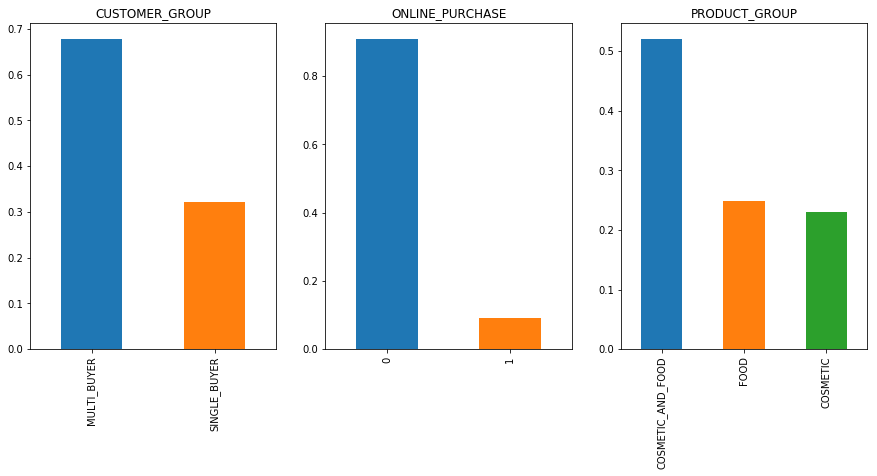

In [11]:
f, ax = plt.subplots(figsize=(15, 6))

plt.subplot(1, 3, 1)
cust_group = customers['CUSTOMER_GROUP'].value_counts()
(cust_group/customers.shape[0]).plot(kind="bar")
plt.title("CUSTOMER_GROUP")


plt.subplot(1, 3, 2)
onln_pur = customers['ONLINE_PURCHASE'].value_counts()
(onln_pur/customers.shape[0]).plot(kind="bar")
plt.title("ONLINE_PURCHASE")


plt.subplot(1, 3, 3)
prod_group = customers['PRODUCT_GROUP'].value_counts()
(prod_group/customers.shape[0]).plot(kind="bar")
plt.title("PRODUCT_GROUP")

plt.show()

In [12]:
print("Number of columns without missing data in the Customers dataset:",len(set(customers.columns[customers.isnull().sum() == 0])))
print("Number of columns without missing data in the Azdias dataset:",len(set(azdias.columns[azdias.isnull().sum() == 0])))

Number of columns without missing data in the Customers dataset: 96
Number of columns without missing data in the Azdias dataset: 93


##### Explore Attribute Data

According to the information given to us "attributes_desc" is a top-level list of attributes and descriptions, organized by informational category. "attributes_values" is a detailed mapping of data values for each feature in alphabetical order.

In [13]:
attributes_desc.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [14]:
attributes_values.head(8)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years


I have manually reviewed the attribute files. We will use the "attributes_desc" file in the following sections to get information about the columns.

What I noticed while inspecting the "attributes_values" file is that some attributes have some descriptions like "unknown" or "no transactions known". We will also examine them in the missing data section.

# 0.2. Data Preparation

## 0.2.1 Dtype Warning

In [15]:
warning_cols = list(azdias.columns[18:20])

In [16]:
# CAMEO_INTL_2015 column is defined in the attribute file as CAMEO_DEUINTL_2015.
attributes_desc[attributes_desc["Attribute"].isin(['CAMEO_DEUG_2015','CAMEO_DEUINTL_2015'])]

,Information level,Attribute,Description,Additional notes
85,Microcell (RR4_ID),CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,New German CAMEO Typology established together...
87,NaN,CAMEO_DEUINTL_2015,CAMEO_4.0: international classification,NaN


In [17]:
def print_unique_values(df,col):
    '''
    INPUT:
    df - Pandas DataFrame
    col - Column List
    
    OUTPUT: No Output
    
    DESC: Returns unique values according to the dataframe and column list given as input.
    '''
    for c in col:
        print(c,df[c].unique())

In [18]:
print_unique_values(azdias,warning_cols)

CAMEO_DEUG_2015 [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']


As you can see, there are both numerical and categorical data in both columns. We also noticed the 'X' and 'XX' columns. We considered these values as missing data.

In [19]:
azdias[warning_cols[0]].replace('X', np.nan, inplace = True)
customers[warning_cols[0]].replace('X', np.nan, inplace = True)
azdias[warning_cols[1]].replace('XX', np.nan, inplace = True)
customers[warning_cols[1]].replace('XX', np.nan, inplace = True)

In [20]:
def convert_object_to_float(df,col):
    '''
    INPUT:
    df - Pandas DataFrame
    col - Column List
    
    OUTPUT:
    df - Pandas DataFrame
    
    DESC: Converts the data type from object to float according to the data frame and column list given as input.
    '''
    for c in col:
        df[c] = df[c].astype(str).astype(float)
    
    return df

In [21]:
customers = convert_object_to_float(customers,warning_cols)
azdias = convert_object_to_float(azdias,warning_cols)

In [22]:
print_unique_values(azdias,warning_cols)

CAMEO_DEUG_2015 [ nan   8.   4.   2.   6.   1.   9.   5.   7.   3.]
CAMEO_INTL_2015 [ nan  51.  24.  12.  43.  54.  22.  14.  13.  15.  33.  41.  34.  55.  25.
  23.  31.  52.  35.  45.  44.  32.]


**Everything looks good now for these 2 columns. We can continue cleaning data.**

## 0.2.2 Missing Value

In [23]:
first_nan_count_customers = customers.isna().sum()
first_nan_count_azdias = azdias.isna().sum()

* In the following sections we take the initial missing data numbers for comparison.

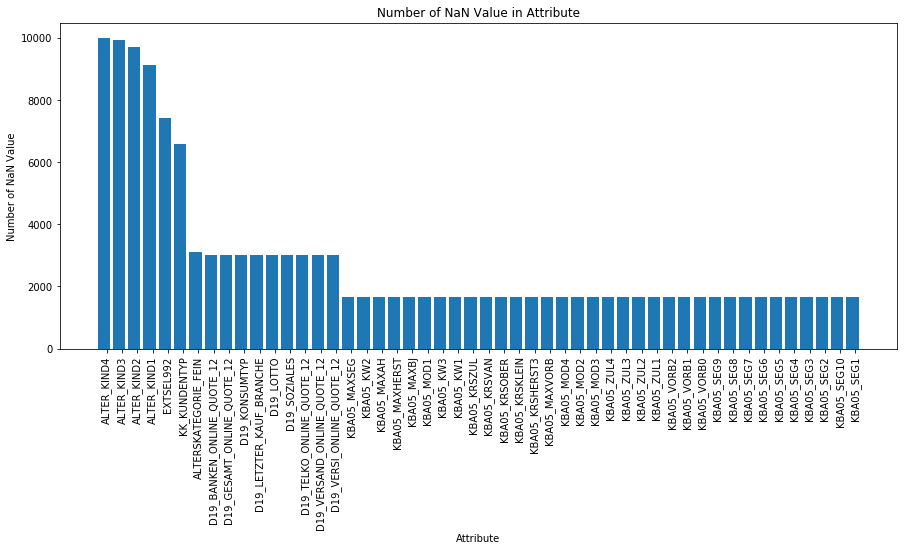

In [24]:
azdias_nan_value = pd.DataFrame(first_nan_count_azdias[first_nan_count_azdias != 0].sort_values(ascending=False)[:50])

X_axis = np.arange(len(azdias_nan_value))
f, ax = plt.subplots(figsize=(15, 6))
plt.bar(X_axis - 0.2, azdias_nan_value[0])
  
plt.xticks(X_axis, azdias_nan_value.index,rotation='vertical')
plt.xlabel("Attribute")
plt.ylabel("Number of NaN Value")
plt.title("Number of NaN Value in Attribute")
plt.legend()
plt.show()

### 0.2.2.1 Explore Attribute file for Missing Value

If you remember, while we were examining the Attribute files, we saw that some values have meanings such as "unknown","no transactions known". We need to use the data from the Attribute file to fix these incorrect values.

* First we will find the values that are "unknown","no transactions known" in the table "attributes_values".
* Some values are written with commas, we will separate them.

In [25]:
attributes_missing = attributes_values[attributes_values['Meaning'].isin(['unknown','unknown / no main age detectable','no transactions known','no transaction known'])]
attributes_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [26]:
def missing_dict(df):
    '''
    INPUT:
    df - Pandas DataFrame 
    
    OUPUT:
    missing_dict - Dictionary
    
    DESC: Combines "unknown" and "no transaction known" values into a dictionary for each column.
    '''

    unknown_values = []
    for val in df.Value:
        if isinstance(val, int):
            unknown_values.append([val])
        elif isinstance(val, str):
            split_list = val.split(',')
            int_list = [int(x) for x in split_list]
            unknown_values.append(int_list)

    unknown_dict = {}
    for attr, value_list in zip(df.Attribute, unknown_values):
        if 'D19' in attr and '_RZ' in attr:
            attr = attr[:-3]
        
        unknown_dict[attr] = value_list

    unknown_dict['ALTERSKATEGORIE_FEIN'] = [0]
    unknown_dict['GEBURTSJAHR'] = [0]
    
    return unknown_dict

In [27]:
missing_dict = missing_dict(attributes_missing)
missing_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_BANKEN_ANZ_12': [0],
 'D19_BANKEN_ANZ_24': [0],
 'D19_BANKEN_DATUM': [10],
 'D19_BANKEN_DIREKT': [0],
 'D19_BANKEN_GROSS': [0],
 'D19_BANKEN_LOKAL': [0],
 'D19_BANKEN_OFFLINE_DATUM': [10],
 'D19_BANKEN_ONLINE_DATUM': [10],
 'D19_BANKEN_REST': [0],
 'D19_BEKLEIDUNG_GEH': [0],
 'D19_BEKLEIDUNG_REST': [0],
 'D19_BILDUNG': [0],
 'D19_BIO_OEKO': [0],
 'D19_BUCH': [0],
 'D19_DIGIT_SERV': [0],
 'D19_DROGERIEARTIKEL': [0],
 'D19_ENERGIE': [0],
 'D19_FREIZEIT': [0],
 'D19_GARTEN': [0],
 'D19_GESAMT_ANZ_12': [0],
 'D19_GESAMT_ANZ_24': [0],
 'D19_GESAMT_DATUM': [10],
 'D19_GESAMT_OFFLINE_DATUM': [10],
 'D19_GESAMT_ONLINE_DATUM': [10],
 'D19_HANDWERK': [0],
 'D19_HAUS_DEKO': [0],
 'D19_KINDERARTIKEL': [0],
 'D19_KK_KUNDENTYP': [-1],
 'D19_KOSMETIK': [0],
 'D19_LEBENSMITTEL': [0],
 'D19

The "missing_dict" dictionary shows us the values in the column that we need to convert to nan.

Now it's time to convert these values to nan.

In [28]:
def change_nan_value(df,missing_dict):
    '''
    INPUT:
    df - Pandas DataFrame
    missing_dict - Dictionary
    
    OUTPUT:
    df - Pandas Dataframe
    
    DESC: Converts values that should be NaN to NaN.
    '''
    
    change_column = []
    for (key,value) in missing_dict.items():

        try:
            df[key].replace(missing_dict[key], np.nan, inplace = True)
            change_column.append(key)
        except:
            continue
            
    return df
    

In [29]:
customers = change_nan_value(customers,missing_dict)
azdias = change_nan_value(azdias,missing_dict)

In [30]:
last_nan_count_customers = customers.isna().sum()
last_nan_count_azdias = customers.isna().sum()

Yes, we now have completely missing values. Now it's time to visualize this missing data to see, compare and determine what to do.

In the first chart, we will see how to compare the number of missing data before and after converting to nan.

In [31]:
nan_values = pd.concat([first_nan_count_azdias, last_nan_count_azdias], axis=1,sort=True)
nan_values['yüzde'] = nan_values[1]/len(azdias)
nan_values = nan_values[nan_values['yüzde']>0.75]

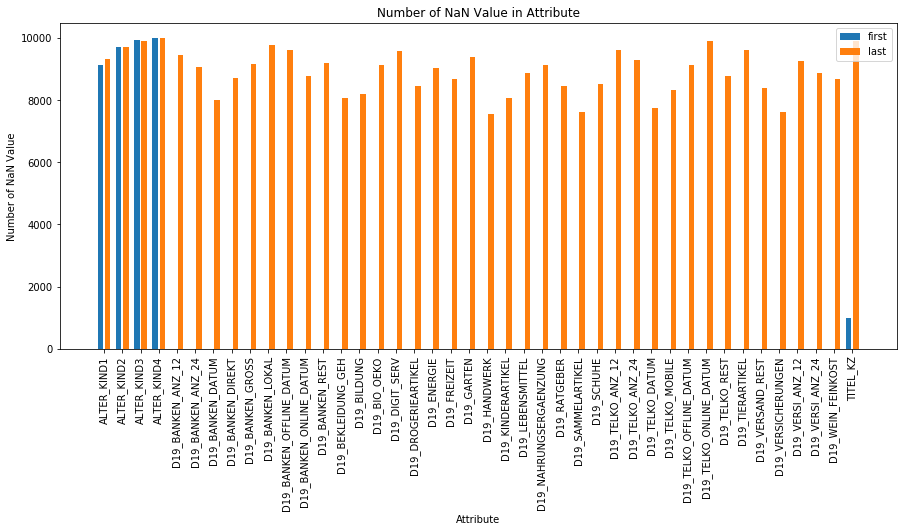

In [32]:
X_axis = np.arange(len(nan_values))
f, ax = plt.subplots(figsize=(15, 6))
plt.bar(X_axis - 0.2, nan_values[0], 0.3, label = 'first')
plt.bar(X_axis + 0.2, nan_values[1], 0.3, label = 'last')
  
plt.xticks(X_axis, nan_values.index,rotation='vertical')
plt.xlabel("Attribute")
plt.ylabel("Number of NaN Value")
plt.title("Number of NaN Value in Attribute")
plt.legend()
plt.show()

In [33]:
nan_values = pd.concat([first_nan_count_customers, last_nan_count_customers], axis=1)
nan_values['yüzde'] = nan_values[1]/len(azdias)
nan_values = nan_values[nan_values['yüzde']>0.75]

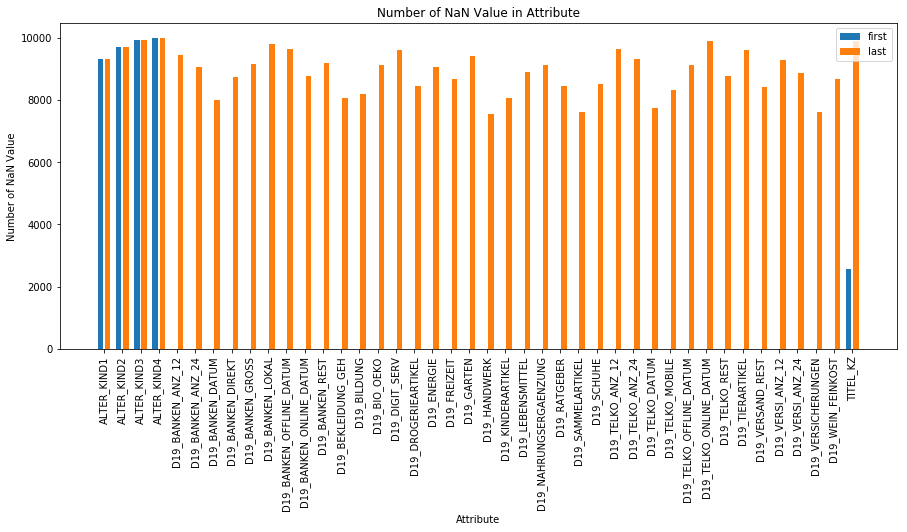

In [34]:
X_axis = np.arange(len(nan_values))
f, ax = plt.subplots(figsize=(15, 6))
plt.bar(X_axis - 0.2, nan_values[0], 0.3, label = 'first')
plt.bar(X_axis + 0.2, nan_values[1], 0.3, label = 'last')
  
plt.xticks(X_axis, nan_values.index,rotation='vertical')
plt.xlabel("Attribute")
plt.ylabel("Number of NaN Value")
plt.title("Number of NaN Value in Attribute")
plt.legend()
plt.show()

In the graphs below, we will see the features in the datasets whose missing data is more than 50% of the total data.

Text(0.5,1,'Percent missing data by feature')

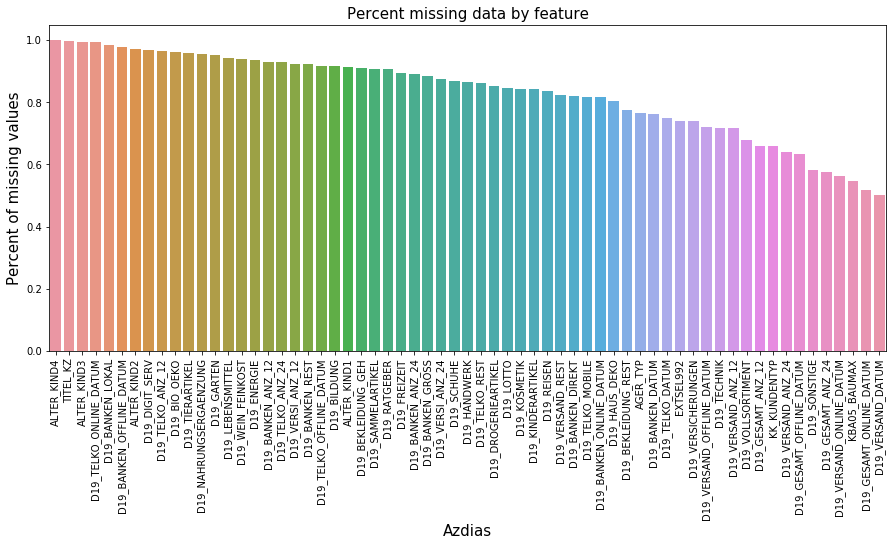

In [35]:
# Percentage of missing values in each dataframe along with visualization
total = azdias.isnull().sum().sort_values(ascending=False)
percent = (azdias.isnull().sum()/azdias.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0.5]
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Azdias', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Text(0.5,1,'Percent missing data by feature')

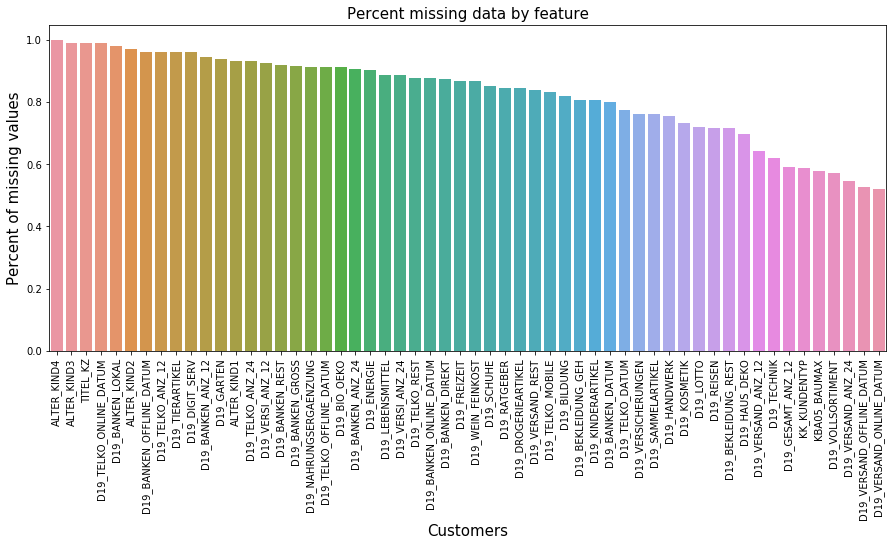

In [36]:
total = customers.isnull().sum().sort_values(ascending=False)
percent = (customers.isnull().sum()/customers.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0.5]
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Customers', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

As you can see in the graphs, almost all of the data with some features is missing data. It would be best to drop these columns.

In [37]:
def missing_column(df,per = 0.75):
    '''
    INPUT:
    df - Pandas DataFrame
    per - float
    
    OUTPUT:
    df - Pandas DataFrame
    
    DESC: Returns a list of columns with a missing data rate higher than the threshold value we set.
    '''
    nan_count_by_column = pd.DataFrame(df.isna().sum() / len(df),columns=['Percentage'])
    nan_count_by_column = nan_count_by_column.sort_values(by=['Percentage'], ascending= False)
    drop_col = list(nan_count_by_column[nan_count_by_column['Percentage'] > per].index)
    
    return drop_col

def drop_column(df,col):
    '''
    INPUT:
    df - Pandas DataFrame
    col - list
    
    OUTPUT:
    df - Pandas DataFrame
    
    DESC: Removes columns from the input list from the dataset.
    '''
    try:
        df = df.drop(col,axis=1)
    except:
        print("Can't drop the column!!")
    
    return df
    

In [38]:
print('Before Dropping:')
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

customers_missing_columns = missing_column(customers)
azdias_missing_columns = missing_column(azdias)

azdias_missing_columns.extend(customers_missing_columns)
drop_col = list(set(azdias_missing_columns))

print(len(drop_col))

azdias = drop_column(azdias,drop_col)
customers = drop_column(customers,drop_col)

print('After Dropping:')
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

Before Dropping:
General Population Dataset Shape:  (10000, 366)
Customer Dataset Shape:  (10000, 369)
48
After Dropping:
General Population Dataset Shape:  (10000, 318)
Customer Dataset Shape:  (10000, 321)


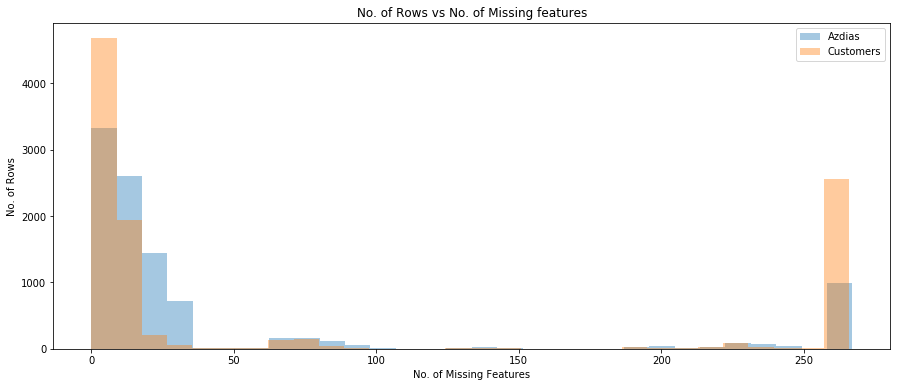

In [39]:
bins = 30
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(111)
ax.set_title("No. of Rows vs No. of Missing features")
ax.set_xlabel("No. of Missing Features")
ax.set_ylabel("No. of Rows")
sns.distplot(azdias.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Azdias")
sns.distplot(customers.isnull().sum(axis=1), bins, kde=False, ax=ax, label="Customers")
ax.legend()
    
plt.show()

In [40]:
def remove_missing_rows(df, threshold):
    '''
    INPUT:
    df - Pandas DataFrame
    threshold - int
    
    OUTPUT:
    df - Pandas DataFrame
    
    DESC: Removes missing data more than the threshold specified in the row.
    '''
    total_rows = df.shape[0]
    
    df = df.dropna(thresh=df.shape[1]-threshold)
    
    removed_rows = total_rows - df.shape[0]
    
    df = df.reset_index().drop(['index'],axis=1)
    
    return df

In [41]:
print('Before Dropping:')
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

customers = remove_missing_rows(customers, threshold=50)
azdias = remove_missing_rows(azdias, threshold=50)

print('After Dropping:')
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

Before Dropping:
General Population Dataset Shape:  (10000, 318)
Customer Dataset Shape:  (10000, 321)
After Dropping:
General Population Dataset Shape:  (8105, 318)
Customer Dataset Shape:  (6893, 321)


## 0.2.3 Categorical Data Cleaning

Now that we have solved most of the missing data problem, we can move on to categorical data. Now let's examine the categorical data we have.

In [42]:
def get_numeric_column_name(df):
    '''
    INPUT: 
    df - Pandas DataFrame
    
    OUTPUT: 
    col - Column list
    
    DESC: Returns the column names that are numeric types in the input dataframe.
    
    '''
    col = df.select_dtypes(include = ['int64','float64']).columns
    
    return col

customers_numeric_col = get_numeric_column_name(customers)
azdias_numeric_col = get_numeric_column_name(azdias)

In [43]:
def get_object_column_name(df):
    '''
    INPUT: 
    df - Dandas DataFrame
    
    OUTPUT: 
    col - Column list
    
    DESC: Returns the column names that are objects types in the input dataframe.
    
    '''
    col = df.select_dtypes('object').columns
    
    return col

customers_object_col = get_object_column_name(customers)
azdias_object_col = get_object_column_name(azdias)

In [44]:
print_unique_values(azdias,azdias_object_col)

CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C' '9B'
 '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
D19_LETZTER_KAUF_BRANCHE [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_SONSTIGE' 'D19_BANKEN_GROSS' 'D19_VOLLSORTIMENT'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_FREIZEIT' 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG'
 'D19_BANKEN_LOKAL']
EINGEFUEGT_AM ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-04-21 00:00:00'
 '1995-02-02 00:00:00' '1

* D19_LETZTER_KAUF_BRANCHE - Indicates the last purchase sector.
* CAMEO_DEU_2015 - Indicates the special group it belongs to.
* EINGEFUEGT_AM - Data insert date.
* OST_WEST_KZ - Flag indicating the former GDR/FRG.

Since the CAMEO_DEU_2015 and D19_LETZTER_KAUF_BRANCHE columns contain very detailed information, we will abandon these columns to simplify our model.

Using only the year column in the EINGEFUEGT_AM column is a good way to simplify our model.

The OST_WEST_KZ column seems quite reasonable for encoding.

In [45]:
customers['EINGEFUEGT_AM'] = pd.to_datetime(customers['EINGEFUEGT_AM'])
customers['EINGEFUEGT_AM_YEAR'] = customers['EINGEFUEGT_AM'].dt.year

azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])
azdias['EINGEFUEGT_AM_YEAR'] = azdias['EINGEFUEGT_AM'].dt.year

In [46]:
print('Before Dropping:')
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

drop_col = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']

azdias = drop_column(azdias,drop_col)
customers = drop_column(customers,drop_col)

print('After Dropping:')
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

Before Dropping:
General Population Dataset Shape:  (8105, 319)
Customer Dataset Shape:  (6893, 322)
After Dropping:
General Population Dataset Shape:  (8105, 316)
Customer Dataset Shape:  (6893, 319)


We have one last thing left to do with categorical data: encode the OST_WEST_KZ column. But before we move on to this, we need to separate the extra columns in the customers verse from the dataset in order not to cause problems in the model we created in the later sections.

In [47]:
extra_columns = list(set(customers.columns) - set(azdias.columns))
extra_columns

['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']

In [48]:
extra_columns_data = customers[extra_columns]
customers = drop_column(customers,extra_columns)

In [49]:
obj_col_customers = get_object_column_name(customers)
obj_col_azdias = get_object_column_name(azdias)

In [50]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col,axis=1),pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)],axis=1)
        except:
            continue
    return df

In [51]:
customers = create_dummy_df(customers, obj_col_customers, False)
azdias = create_dummy_df(azdias, obj_col_azdias, False)

In [52]:
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

General Population Dataset Shape:  (8105, 316)
Customer Dataset Shape:  (6893, 316)


## 0.2.4 Unique Value

Since the columns that are the same as the number of datasets are id or index, these columns identify the person or row. Therefore, we cannot extract features from these columns.

In [53]:
for col in customers.columns:
    if len(customers[col].unique()) == len(customers):
        LNR_customers = customers[col]
        customers = customers.drop([col],axis=1)
        print(col,'is dropped from customers.')
        
for col in azdias.columns:
    if len(azdias[col].unique()) == len(azdias):
        LNR_azdias = azdias[col]
        azdias = azdias.drop([col],axis=1)
        print(col,'is dropped from azdias.')

LNR is dropped from customers.
LNR is dropped from azdias.


**LNR column is something like id or index. Therefore, this column has been dropped.**

## 0.2.5 Imputing Missing Values

Text(0.5,1,'Percent missing data by feature')

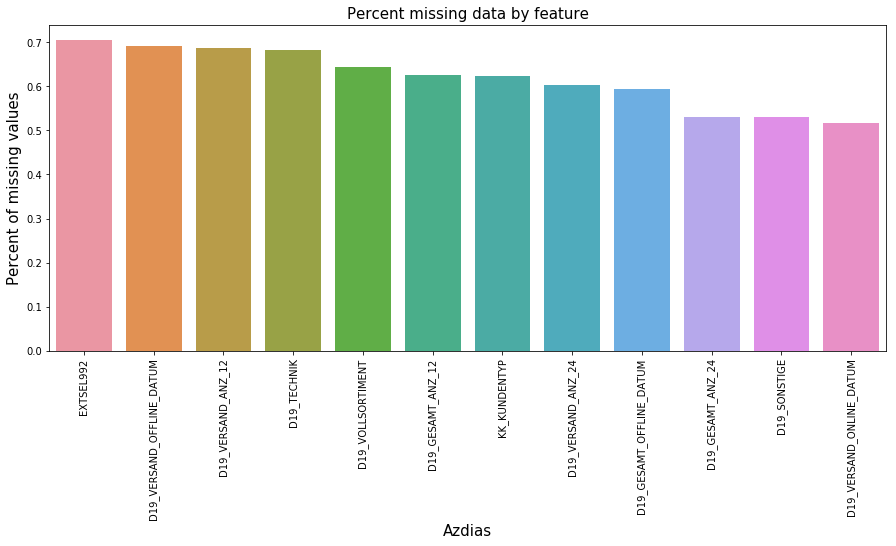

In [54]:
total = azdias.isnull().sum().sort_values(ascending=False)
percent = (azdias.isnull().sum()/azdias.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0.5]
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Azdias', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Until we got to this stage, we deleted many columns and lost data. But there are still missing data as seen in the chart above. Now it's time to fill in this data. Missing data are usually filled in with the mean or most common values.

We will fill in our missing data by assigning the most common data, which is the most appropriate method for demographic data.

In [55]:
def fill_missing_value(df,missing_value = 'NaN',strategy = 'most_frequent'):
    '''
    INPUT:
    df - Pandas DataFrame
    missing_value - string
    strategy - string
    
    OUTPUT:
    df - Pandas DataFrame
    
    DESC: Fills the missing data in the Data Set according to the specified strategy.
    '''
    col = df.columns
    
    imputer = Imputer(missing_values=missing_value, strategy=strategy, axis=0)
    df = imputer.fit_transform(df)
    
    return pd.DataFrame(df,columns = col)

In [56]:
customers = fill_missing_value(customers)
azdias = fill_missing_value(azdias)

In [57]:
print('Number of missing data in Azdias dataset:',np.sum(azdias.isna().sum()))
print('Number of missing data in Customers dataset:',np.sum(customers.isna().sum()))

Number of missing data in Azdias dataset: 0
Number of missing data in Customers dataset: 0


## 0.2.6 Standardizing Data

**We no longer have missing data... We can celebrate that. Because we've come a long way.**

But there is one last step left to complete the data preprocessing step. In order not to mislead the data into our model, we need to pass it through the standardization process.

In [58]:
def standartize_data(df):
    '''
    INPUT:
    df - Pandas DataFrame
    
    OUTPUT: 
    df - Pandas DataFrame
    scale - trained model
    
    DESC: Standardizes the given dataset.
    '''

    scale = StandardScaler(copy=False)

    df[df.columns] = scale.fit_transform(df)
    
    return df, scale

In [59]:
azdias,scale = standartize_data(azdias)
col = customers.columns
customers[col] = scale.transform(customers)

In [60]:
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_YEAR,OST_WEST_KZ_W
0,1.266336,0.568824,2.066766,0.193916,-0.115906,-0.302206,0.224317,0.328199,-0.06182,-0.180699,...,1.070694,1.465259,-0.739848,0.578743,-0.031663,1.133877,0.938820,-1.665273,-0.440272,0.536218
1,1.266336,0.275565,0.801335,0.126456,-0.115906,-0.302206,-0.611971,-0.030908,-0.06182,-0.180699,...,0.455562,0.029278,-0.739848,0.578743,-1.096515,1.133877,0.938820,0.184143,-0.440272,0.536218
2,-0.935633,-0.897469,-0.464095,-0.480686,-0.115906,-0.302206,-1.448259,-0.390016,-0.06182,-1.186584,...,0.763128,1.824255,0.952317,0.578743,1.565615,-0.297710,0.938820,1.108851,1.620721,0.536218
3,-0.935633,1.155341,-0.147738,-0.345766,-0.115906,-0.302206,1.896894,-0.318194,-0.06182,0.825186,...,-0.774702,-0.688713,-1.303903,0.578743,-0.564089,0.418083,-1.065167,0.184143,-0.440272,0.536218
4,-0.935633,-1.777245,-1.413169,-0.210845,-0.115906,-0.302206,-0.611971,-0.390016,-0.06182,-1.186584,...,-0.159570,-0.688713,0.952317,0.578743,1.565615,0.418083,0.938820,-1.665273,-0.440272,0.536218


In [61]:
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_YEAR,OST_WEST_KZ_W
0,-0.935633,-1.777245,-1.413169,-0.480686,-0.115906,-0.302206,0.224317,-0.461837,-0.06182,-2.192469,...,-1.389834,-1.406704,0.952317,0.578743,1.565615,-0.297710,-1.065167,1.108851,-0.440272,0.536218
1,-0.935633,-2.950280,-1.413169,-0.480686,-0.115906,-0.302206,-0.611971,-0.461837,-0.06182,-0.180699,...,1.685826,1.824255,0.952317,0.578743,-1.096515,-0.297710,0.938820,1.108851,-0.440272,0.536218
2,-0.935633,-2.363762,-2.045884,-0.548146,-0.115906,-0.302206,-1.448259,-0.461837,-0.06182,-2.192469,...,-1.082268,-1.406704,0.952317,0.578743,1.565615,-1.729297,-1.065167,1.108851,-0.440272,0.536218
3,-0.935633,1.155341,-0.147738,-0.075925,-0.115906,-0.302206,1.896894,-0.030908,-0.06182,-0.180699,...,-0.774702,-0.688713,-1.303903,0.578743,-0.564089,-1.729297,-1.065167,0.184143,-0.440272,0.536218
4,-0.935633,-1.483986,-1.413169,-0.480686,-0.115906,-0.302206,0.224317,-0.461837,-0.06182,-0.180699,...,-1.697400,-1.765699,0.952317,0.578743,-1.628941,-1.013503,-1.065167,0.184143,-0.440272,0.536218


In [62]:
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)

General Population Dataset Shape:  (8105, 315)
Customer Dataset Shape:  (6893, 315)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# 1.1. Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques. 

When the number of features/variables is very large relative to the number of observations in your dataset, certain algorithms struggle to train effective models. This is called the “Curse of Dimensionality”. To get rid of this curse, we apply the Dimensionality Reduction technique. In this technique, the aim is to determine the columns that will not affect the result, to reduce the calculation cost and to increase the calculation speed.

We will use the PCA algorithm, which is the most widely used algorithm for Dimensionality Reduction.

In [63]:
def pca_without_component(df):
    '''
    INPUT:
    df - Pandas Dataframe
    
    OUTPUT:
    df_pca - Pandas Dataframe
    pca - trained model
    
    DESC: Trains the PCA model with the input dataset.
    '''
    pca = PCA()
    df_pca = pca.fit_transform(df)
    
    return df_pca, pca

In [64]:
azdias_pca, pca = pca_without_component(azdias)

In [65]:
def find_pca_component_number(pca):
    '''
    INPUT:
    pca - trained model
    
    OUTPUT:
    No Output
    
    DESC: Finds the number of components by visualizing the trained PCA model.
    '''
    plt.rcParams["figure.figsize"] = (20,8)

    fig, ax = plt.subplots()
    xi = np.arange(len(pca.explained_variance_ratio_))
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    i = np.argmax(y > 0.95)

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.85, 'Number of components we need: '+ str(i), color = 'red', fontsize=13)

    ax.grid(axis='x')
    plt.show()
    
    return i
    

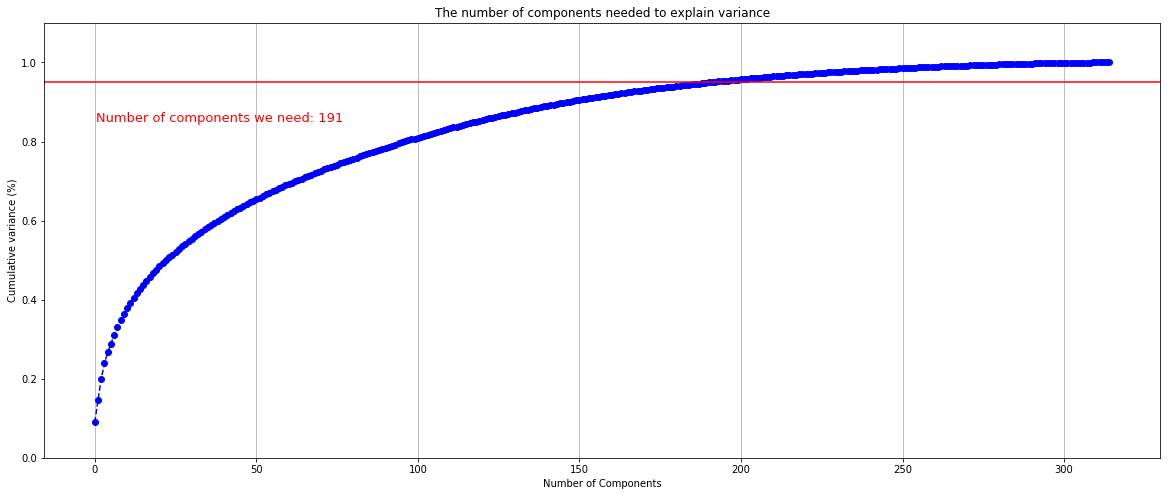

In [66]:
component_number = find_pca_component_number(pca)

In [67]:
def pca_with_component(df, component):
    '''
    INPUT:
    df - Pandas DataFrame
    component - int
    
    OUTPUT:
    df_pca - Pandas DataFrame
    pca - trained model
    
    DESC: Trains the PCA model with the input dataset and the specified number of components.
    '''
    pca = PCA(component)
    df_pca = pca.fit_transform(df)
    
    return df_pca, pca

In [68]:
azdias_pca, pca  = pca_with_component(azdias,component_number)
customers_pca = pca.transform(customers)

In [69]:
def pca_interpretation(df, pca, i):
    '''
    INPUT:
    df - Pandas DataFrame
    pca - trained model
    i - int
    
    OUTPUT:
    No Output
    
    DESC: Creates graph to discuss desired Principial Component.
    '''
    feature_weights = dict(zip(df.columns.values, pca.components_[i]))
    sorted_feature_weights = sorted(feature_weights.items(), key=operator.itemgetter(1), reverse=True)
    
    features = pd.DataFrame(sorted_feature_weights).iloc[np.r_[:3,  -3, -2, -1],:]
    feature_names = features[0].values
    weights = features[1].values

    sns.set(style='whitegrid')
    sns.set_color_codes('bright')
    fig = plt.figure(figsize=(10, 5))
    sns.set()

    ax = sns.barplot(x=weights, y=feature_names)
    ax.set(xlabel="Weight", ylabel="Feature", title=f'{i+1}.Principial Component')
    
    

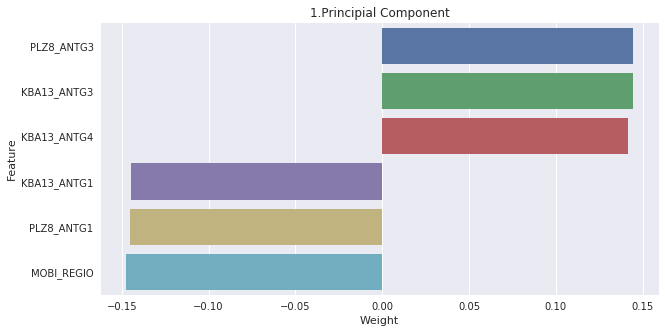

In [70]:
pca_interpretation(azdias, pca, 0)

Highest:

* PLZ8_ANTG3 is number of 6-10 family houses in the PLZ8 (3 = high share)
* KBA13_ANTG3 is number of 6-10 family houses in the cell (3 = high share of 6-10 family homes)
* KBA13_ANTG4 is number of >10 family houses in the cell (2 = high share of >10 family homes)

Lowest:

* KBA13_ANTG1 is number of 1-2 family houses in the cell (4 = very high share of 1-2 family homes)
* PLZ8_ANTG1 is number of 1-2 family houses in the PLZ8 (1 = very high)
* MOBI_REGIO is mobility patterns (1 = very high)

**1.Principial Component is an indicator of the number of share family in the house.**

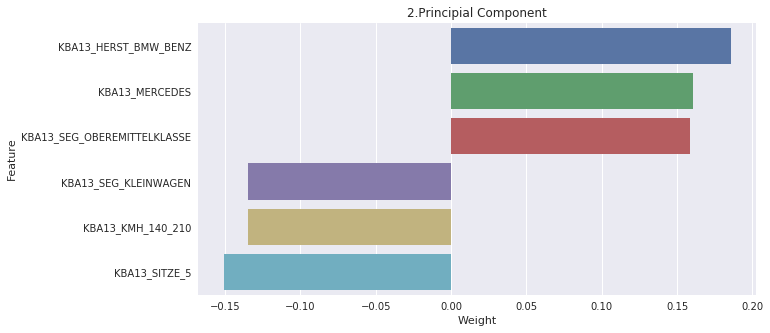

In [71]:
pca_interpretation(azdias, pca, 1)

Highest:

* KBA13_HERST_BMW_BENZ is share of BMW & Mercedes Benz within the PLZ8 (5 = very high)
* KBA13_MERCEDES is share of MERCEDES within the PLZ8 (5 = very high)
* KBA13_SEG_OBEREMITTELKLASSE is share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.) (5 = very high)

Lowest:

* KBA13_SEG_KLEINWAGEN is share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8 (5 = very high)
* KBA13_KMH_140_210 is share of cars with max speed between 140 and 210 km/h within the PLZ8 (5 = very high)
* KBA13_SITZE_5 is number of cars with 5 seats in the PLZ8 (5 = very high)

**2.Principial Component is obviously an indicator of Cars related properties.**

# 1.2. Customer Segmentation with K-Means Algorithm

K-means is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid. 

The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid.

In [85]:
wcss = []
for i in range(2,20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(azdias_pca)
    wcss.append(kmeans.inertia_)

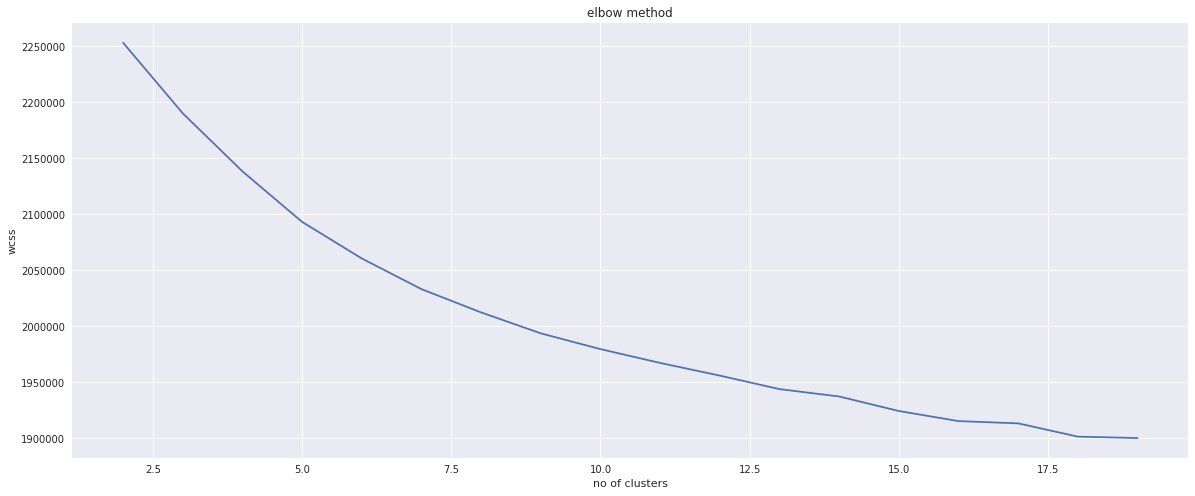

In [86]:
plt.plot(range(2,20), wcss)
plt.title("elbow method")
plt.xlabel("no of clusters")
plt.ylabel("wcss")
plt.show()

In [87]:
kmeans = KMeans(n_init=10, init="k-means++", n_clusters=7, max_iter=300, random_state=0)
azdias_pred = kmeans.fit_predict(azdias_pca)
customers_pred = kmeans.predict(customers_pca)

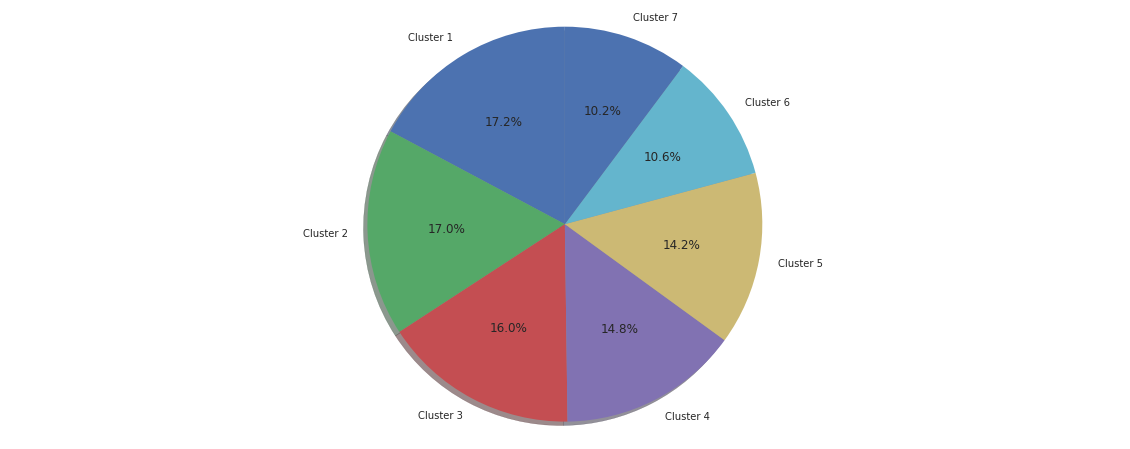

In [88]:
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']
sizes = pd.DataFrame(azdias_pred)[0].value_counts()
explode = (0, 0, 0, 0, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [89]:
azdias_preds = pd.DataFrame({'LNR': LNR_azdias, 'Clusters': azdias_pred})
customers_preds = pd.DataFrame({'LNR': LNR_customers, 'Clusters': customers_pred})

In [90]:
general_proportions = Counter(azdias_preds['Clusters'])
customers_proportions = Counter(customers_preds['Clusters'])

In [91]:
for k, v in general_proportions.items():
    general_proportions[k] = v / len(azdias)
    
for k, v in customers_proportions.items():
    customers_proportions[k] = v / len(customers)

In [92]:
df_props = pd.DataFrame(columns=["Dataset", "Cluster", "Proportions", 'Difference'])
for k, v in customers_proportions.items():
    df_props = df_props.append({"Dataset" : "customer", "Cluster": k, "Proportions": v}, ignore_index=True)

for k, v in general_proportions.items():
    df_props = df_props.append({"Dataset" : "general", "Cluster": k, "Proportions": v}, ignore_index=True)

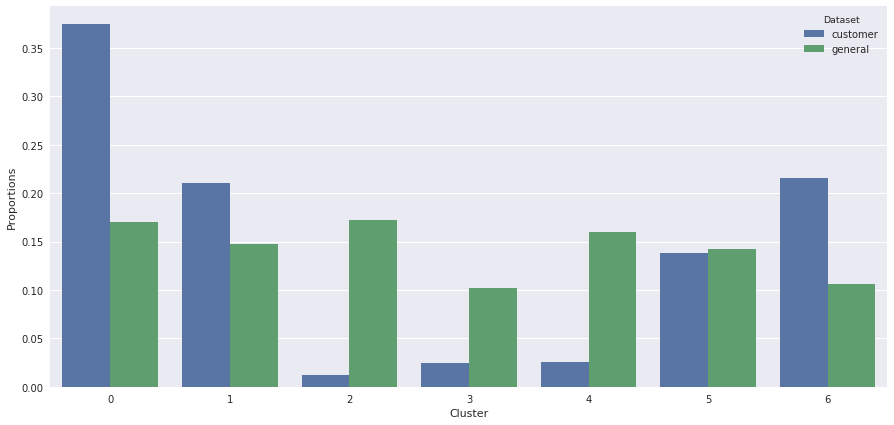

In [93]:
fig = plt.figure(figsize=(15,7))
sns.barplot(x="Cluster", y="Proportions", hue="Dataset", data=df_props)

In [94]:
kmeans.cluster_centers_[4][:3]

array([ 7.13539736,  1.56151328,  2.26217448])

In [95]:
kmeans.cluster_centers_[0][:3]

array([-5.08334159, -0.74791755, -3.35492585])

In [96]:
kmeans.cluster_centers_[1][:3]

array([-5.74671569, -1.40717163,  3.52846024])

In [ ]:
def build_model(pca_n, n_clusters):
    '''Creates a pipeline for doing KMeans clustering
    
    Args:
        pca_n (int): number of pca components
        n_clusters (int): number of clusters
    
    Returns:
        pipeline (sklearn.pipeline.Pipeline)
    '''
    pipeline = Pipeline([
            ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', StandardScaler()),
            ('pca', PCA(pca_n)),
            ('kmeans', KMeans(n_clusters=n_clusters))
    ])
    
    return pipeline

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [97]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';',nrows=10000)

In [98]:
mailout_train.shape

(10000, 367)

In [99]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Text(0.5,1,'Response Value Count')

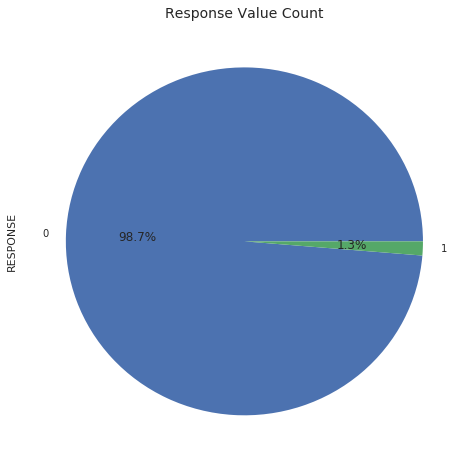

In [110]:
pie, ax = plt.subplots(figsize=[8,8])
mailout_train.RESPONSE.value_counts().plot.pie(autopct="%.1f%%")
plt.title("Response Value Count", fontsize=14)

In [116]:
def process_data(df):
    '''
    INPUT:
    df - 
    
    OUTPUT:
    df - 
    LNR_df - 
    RESPONSE_df - 
    
    DESC:
    '''
    warning_cols = list(df.columns[18:20])
    
    df[warning_cols[0]].replace('X', np.nan, inplace = True)
    df[warning_cols[1]].replace('XX', np.nan, inplace = True)
    
    df = change_nan_value(df,missing_dict)
    
    df_missing_columns = missing_column(df)

    df = drop_column(df,df_missing_columns)
    
    df = remove_missing_rows(df, threshold=50)

    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    df['EINGEFUEGT_AM_YEAR'] = df['EINGEFUEGT_AM'].dt.year
    
    drop_col = ['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM']

    df = drop_column(df,drop_col)
    
    obj_col_df = get_object_column_name(df)
    
    df = create_dummy_df(df, obj_col_df, False)
    
    LNR_df = df['LNR']
    RESPONSE_df = df['RESPONSE']
    df = df.drop(['LNR','RESPONSE'],axis=1)
    
    df = fill_missing_value(df)
    
    return df, LNR_df, RESPONSE_df
    

In [117]:
clean_mailout_train,mailout_train_LNR,mailout_train_RESPONSE = process_data(mailout_train)

In [118]:
clean_mailout_train.shape

(7860, 324)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(clean_mailout_train, mailout_train_RESPONSE, stratify=labels, test_size=0.2, random_state=SEED)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')